In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import dill
import pickle
import matplotlib.pylab as plt
import dataframe_image as dfi

output_dir = u'output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
tf_idf = TfidfVectorizer(ngram_range=(1,2), max_df=0.5, min_df=2)

In [2]:
# 计算各项评价指标
def eval_model(y_true, y_pred):
    labels = ['Irrelevant','Relevant']
    # 计算每个分类的Precision, Recall, f1, support
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred)
    # 计算总体的平均Precision, Recall, f1, support
    tot_p = np.average(p, weights=s)
    tot_r = np.average(r, weights=s)
    tot_f1 = np.average(f1, weights=s)
    tot_s = np.sum(s)
    res1 = pd.DataFrame({
        u'Label': labels,
        u'Precision': p,
        u'Recall': r,
        u'F1': f1,
        u'Support': s
    })
    
    res2 = pd.DataFrame({
        u'Label': [u'总体'],
        u'Precision': [tot_p],
        u'Recall': [tot_r],
        u'F1': [tot_f1],
        u'Support': [tot_s]
    })
    res2.index = [999]
    res = pd.concat([res1, res2])
    dfi.export(obj=res, filename='./data/new/图片/eval_model.jpg')
    return res[[u'Label', u'Precision', u'Recall', u'F1', u'Support']]

def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat, cmap='Greens')
    plt.title('Confusion Matrix')
    plt.colorbar()
    for i in range(len(confusion_mat)): 
        for j in range(len(confusion_mat)):
            plt.annotate(confusion_mat[i,j], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    labels = ['Irrelevant', 'Relevant']
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.savefig('./data/new/图片/混淆矩阵.jpg')
    plt.show()

In [ ]:
#训练模型

In [24]:
data = pd.read_csv('./data/battery/train.txt', sep = '\t', header=0, names=['Title','Abstract','Relevance'])
data.head()

,Title,Abstract,Relevance
0,\n Replacing conventional battery electrolyte ...,Solid electrolyte interphases generated using ...,1
1,\n Revisiting metal fluorides as lithium-ion b...,"Metal fluorides, promising lithium-ion battery...",1
2,\n A four-electron Zn-I2 aqueous battery enabl...,Electrochemically reversible redox couples tha...,1
3,\n A cooperative biphasic MoOx–MoPx promoter e...,The realisation of fast-charging lithium-ion b...,1
4,\n Dynamically visualizing battery reactions b...,Energy storage devices using electrochemical r...,1


In [25]:
x = data['Abstract']
y = data['Relevance']

In [26]:
X = tf_idf.fit_transform(x.values.astype('U'))
X

<5049x92866 sparse matrix of type '<class 'numpy.float64'>'
	with 985930 stored elements in Compressed Sparse Row format>

In [27]:
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [29]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [30]:
y_test_pred = model.predict(X_test)

In [ ]:
#评估模型

In [31]:
model.score(X_test,y_test)

0.8405940594059406

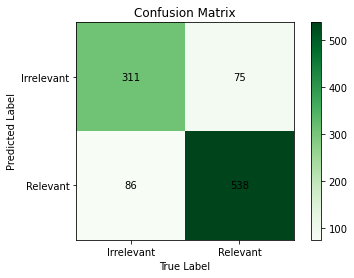

,Label,Precision,Recall,F1,Support
0,Irrelevant,0.805699,0.783375,0.794381,397
1,Relevant,0.862179,0.877651,0.869846,613
999,总体,0.839979,0.840594,0.840183,1010


In [32]:
confusion_mat = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(confusion_mat)
eval_model(y_test, y_test_pred)

In [ ]:
#保存模型

In [3]:
model_file = os.path.join(output_dir, u'model_anode.pkl')
with open(model_file, 'wb') as outfile:
    dill.dump({
        'y_encoder': y_encoder,
        'tfidf': tf_idf,
        'lr': model
    }, outfile)

NameError: name 'y_encoder' is not defined

In [ ]:
#使用模型对语料库分类

In [88]:
new_data = pd.read_csv('./data/new/new.txt', sep = '\t', header=None, names=['Title','Abstract','Relevance'])
new_data

,Title,Abstract,Relevance
0,\n A highly stable and flexible...,Solid-state lithium (Li)–air batteries are rec...,1
1,\n Visualizing plating-induced ...,Lithium dendrite (filament) propagation throug...,1
2,\n Monocarborane cluster as a s...,High-energy-density and low-cost calcium (Ca) ...,1
3,\n Replacing conventional batte...,Solid electrolyte interphases generated using ...,1
4,\n Ultra-high-voltage Ni-rich l...,"By increasing the charging voltage, a cell spe...",1
...,...,...,...
329,\n Cost of wind energy generati...,The statistic of wind energy in the US is pres...,0
330,\n Pressure-induced tuning of l...,As a new class of multi-principal component ox...,0
331,\n Multifunctional electrochrom...,With the advent of multifunctional devices wit...,0
332,\n Electrochemical generation o...,"It has recently been shown that sulfur, a soli...",0


In [89]:
model_file = os.path.join(output_dir, u'model_cathode.pkl')
with open(model_file, 'rb') as infile:
    model = pickle.load(infile)

In [90]:
new_x = model['tfidf'].transform(new_data[u'Abstract'].values.astype('U'))

In [91]:
new_y_pred = model['lr'].predict(new_x)
new_y_pred

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

In [92]:
df2=pd.DataFrame({u'预测相关性': model['y_encoder'].inverse_transform(new_y_pred), u'实际相关性': new_data[u'Relevance'], u'Abstract':new_data[u'Abstract']})
df2

,预测相关性,实际相关性,Abstract
0,1,1,Solid-state lithium (Li)–air batteries are rec...
1,0,1,Lithium dendrite (filament) propagation throug...
2,0,1,High-energy-density and low-cost calcium (Ca) ...
3,0,1,Solid electrolyte interphases generated using ...
4,1,1,"By increasing the charging voltage, a cell spe..."
...,...,...,...
329,0,0,The statistic of wind energy in the US is pres...
330,0,0,As a new class of multi-principal component ox...
331,0,0,With the advent of multifunctional devices wit...
332,0,0,"It has recently been shown that sulfur, a soli..."


In [93]:
np.bincount(model['y_encoder'].inverse_transform(new_y_pred))

array([249,  85], dtype=int64)

In [94]:
df2.to_csv('./data/new/data.csv')

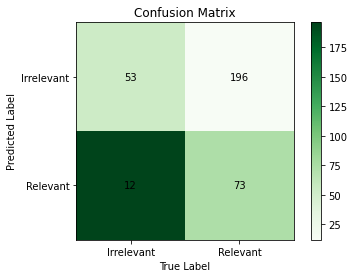

,Label,Precision,Recall,F1,Support
0,Irrelevant,0.212851,0.815385,0.337580,65
1,Relevant,0.858824,0.271375,0.412429,269
999,总体,0.733110,0.377246,0.397863,334


In [95]:
confusion_mat = confusion_matrix(new_data[u'Relevance'], model['y_encoder'].inverse_transform(new_y_pred))
plot_confusion_matrix(confusion_mat)
eval_model(new_data[u'Relevance'], model['y_encoder'].inverse_transform(new_y_pred))